In [1]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

# データ読み込み

In [10]:
# train_dfはland_dataの特徴量を限定→欠損除去→販売間隔1日以上のデータ
train_df = pd.read_csv(r"D:\fujiwara\M\data\after_preprocess\land_train_df.csv")


In [41]:
# train_df_tempはland_dataの特徴量を限定→欠損除去→販売間隔1日以上→登記日が2014~2018年→1万件抽出のデータ
train_df_temp = pd.read_csv(r"D:\fujiwara\M\data\after_preprocess\land_train_df_temp.csv")

# 特徴量生成

In [42]:
# 各都道府県の人口密度データを辞書形式で用意(令和2年度，最新版)　1km2あたりの人口
prefecture_density = {
    '北海道': 66.6, '青森県': 128.3, '岩手県': 79.2, '宮城県': 316.1, '秋田県': 82.4,
    '山形県': 114.6, '福島県': 133.0, '茨城県': 470.2, '栃木県': 301.7, '群馬県': 304.8,
    '埼玉県': 1934.0, '千葉県': 1218.5, '東京都': 6402.6, '神奈川県': 3823.2, '新潟県': 174.9,
    '富山県': 243.6, '石川県': 270.5, '福井県': 183.0, '山梨県': 181.4, '長野県': 151.0,
    '岐阜県': 186.3, '静岡県': 467.2, '愛知県': 1458.0, '三重県': 306.6, '滋賀県': 351.9,
    '京都府': 559.0, '大阪府': 4638.4, '兵庫県': 650.5, '奈良県': 358.8, '和歌山県': 195.3,
    '鳥取県': 157.8, '島根県': 100.1, '岡山県': 265.4, '広島県': 330.2, '山口県': 219.6,
    '徳島県': 173.5, '香川県': 506.3, '愛媛県': 235.2, '高知県': 97.3, '福岡県': 1029.8,
    '佐賀県': 332.5, '長崎県': 317.7, '熊本県': 234.6, '大分県': 177.2, '宮崎県': 138.3,
    '鹿児島県': 172.9, '沖縄県': 642.9
}

# DataFrameに人口密度カラムを追加
# train_df['population_density'] = train_df['pref'].map(prefecture_density)
train_df_temp['population_density'] = train_df_temp['pref'].map(prefecture_density)

## 登記月

In [43]:
# train_df['month_sin'] = np.sin(2 * np.pi * train_df['month'] / 12)
train_df_temp['month_sin'] = np.sin(2 * np.pi * train_df_temp['month'] / 12)

In [44]:
# 'pref', 'month'をdropする
# train_df = train_df.drop(columns=['pref', 'month'])
train_df_temp = train_df_temp.drop(columns=['pref', 'month'])


# 順序ロジスティック回帰

In [45]:
# 目的変数の作成
# sales1_periodを1年ごとのカテゴリに変換
def categorize_period(days):
    # 欠損値を除外
    if pd.isnull(days):
        return np.nan
    elif days == 0:
        return np.nan
    elif days <= 365:
        return 1
    elif days <= 365 * 2:
        return 2
    elif days <= 365 * 3 + 1:
        return 3
    elif days <= 365 * 4 + 1:
        return 4
    elif days <= 365 * 5 + 1:
        return 5
    # 5年を超える場合は、欠損値として扱う
    else:
        return np.nan

In [46]:
# ====== 1. train_df_tempにsales1_categoryを追加 ======
train_df_temp['sales1_category'] = train_df_temp['days_between_sales'].apply(categorize_period)

In [47]:
# 各カテゴリの数
sales1_category_counts = train_df_temp['sales1_category'].value_counts()
print(sales1_category_counts)

sales1_category
1    7200
2    1419
3     603
4     424
5     354
Name: count, dtype: int64


In [48]:
train_df['register_date'] = pd.to_datetime(train_df['register_date'])
train_df_temp['register_date'] = pd.to_datetime(train_df_temp['register_date'])

In [21]:
# train_dfをtrain_df_tempとtrain_dfのテストデータ期間である2019年から2023年のデータを結合
train_df_all = pd.concat([train_df[(train_df['register_date'] >= '2019-01-01') & (train_df['register_date'] < '2024-01-01')], train_df_temp])
# train_df をdatetimeで並べ替え
train_df_all = train_df_all.sort_values("register_date")

In [49]:
len(train_df[(train_df['register_date'] >= '2019-01-01') & (train_df['register_date'] < '2024-01-01')])

341187

In [50]:
train_df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   days_between_sales  10000 non-null  float64       
 1   register_date       10000 non-null  datetime64[ns]
 2   size                10000 non-null  float64       
 3   use_district        10000 non-null  object        
 4   sales1_category     10000 non-null  int64         
 5   population_density  10000 non-null  float64       
 6   month_sin           10000 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 547.0+ KB


In [51]:
# test_dfを読み込み
test_df = pd.read_csv(r"D:\fujiwara\M\data\after_preprocess\land_test_df.csv")
# test_dfの登記日をdatetime型に変換 
test_df['register_date'] = pd.to_datetime(test_df['register_date'])

In [52]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   days_between_sales  10000 non-null  float64       
 1   register_date       10000 non-null  datetime64[ns]
 2   pref                10000 non-null  object        
 3   month               10000 non-null  int64         
 4   size                10000 non-null  float64       
 5   use_district        10000 non-null  object        
 6   sales1_category     10000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 547.0+ KB



==== 評価結果 ====
Accuracy: 0.8502
MAE     : 0.1944

==== 混同行列 ====
         予測:〜1年  予測:1〜2年  予測:2〜3年  予測:3〜4年  予測:4〜5年
実際:〜1年     8502        0        0        0        0
実際:1〜2年    1174        0        0        0        0
実際:2〜3年     227        0        0        0        0
実際:3〜4年      72        0        0        0        0
実際:4〜5年      25        0        0        0        0


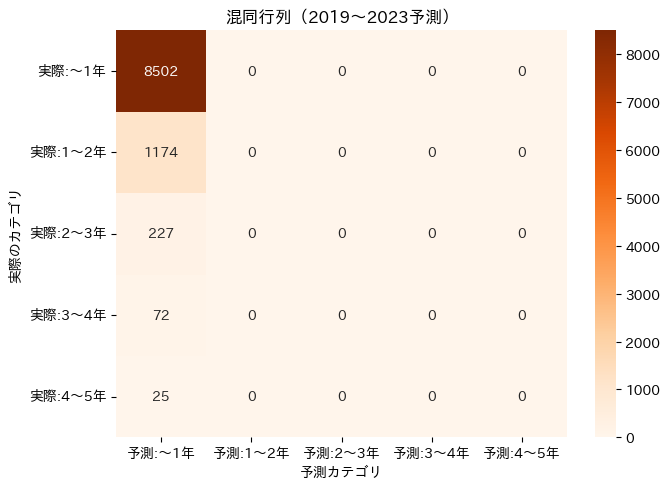

In [53]:
from collections import Counter
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix
from statsmodels.miscmodels.ordinal_model import OrderedModel

train_df_temp = pd.get_dummies(train_df_temp, columns=['use_district'], prefix='dummy', drop_first=True, dtype=float)
test_df = pd.get_dummies(test_df, columns=['use_district'], prefix='dummy', drop_first=True, dtype=float)

# ====== 4. 説明変数・目的変数・日付に分離 ======
#月の循環的性質を表現する
# monthをint型に,sizeをfloat型に変換
# 'month'列を数値に変換（もし既にintならこの処理は安全）
# train_df_all['month'] = pd.to_numeric(train_df_all['month'], errors='coerce')
# train_df_all['month'] = train_df_all['month'].astype(int)

# train_df_all['size'] = pd.to_numeric(train_df_all['size'], errors='coerce')

# train_df_temp['month_sin'] = np.sin(2 * np.pi * train_df_temp['month'] / 12)
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month'] / 12)
# 人口密度に変換
# train_df_temp['population_density'] = train_df_temp['pref'].map(prefecture_density)
test_df['population_density'] = test_df['pref'].map(prefecture_density)

# 欠損除去
train_df_temp = train_df_temp.dropna()
test_df = test_df.dropna()

quantitative_cols = ['population_density', 'size']
# X_all = train_df_all.drop(['days_between_sales', 'pref','month', 'sales1_category', 'register_date'], axis=1)
# y_all = train_df_all['sales1_category']
# date_all = train_df_all['register_date']

# # ====== 5. 時系列ホールドアウト（2014〜2018: train, 2019〜2023: test）======
# train_mask = date_all < pd.to_datetime("2019-01-01")
# test_mask = date_all >= pd.to_datetime("2019-01-01")

X_train = train_df_temp.drop(['days_between_sales', 'sales1_category', 'register_date'], axis=1).copy()
X_test = test_df.drop(['days_between_sales', 'pref','month', 'sales1_category', 'register_date'], axis=1).copy()
y_train = train_df_temp['sales1_category'].astype(int)
y_test = test_df['sales1_category'].astype(int)

# ====== 6. 標準化（量的変数のみ）======
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[quantitative_cols] = scaler.fit_transform(X_train[quantitative_cols])
X_test[quantitative_cols] = scaler.transform(X_test[quantitative_cols])

# ====== 7. モデル構築と学習 ======
model = OrderedModel(y_train, X_train, distr='logit')
result = model.fit(method='bfgs', disp=False)

# ====== 8. 予測（出力は0始まりなので+1）======
pred_probs = result.predict(X_test)
y_pred = pred_probs.idxmax(axis=1).astype(int) + 1

# ====== 9. 評価指標の計算 ======
accuracy = accuracy_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n==== 評価結果 ====")
print(f"Accuracy: {accuracy:.4f}")
print(f"MAE     : {mae:.4f}")

# ====== 10. 混同行列の可視化 ======
category_labels = {
    1: '〜1年', 2: '1〜2年', 3: '2〜3年', 4: '3〜4年', 5: '4〜5年'
}

# y_trainとy_testのユニークな値を取得
y_all = pd.concat([y_train, y_test])
unique_labels = sorted(y_all.unique())

cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
cm_df = pd.DataFrame(cm,
    index=[f"実際:{category_labels[i]}" for i in unique_labels],
    columns=[f"予測:{category_labels[i]}" for i in unique_labels]
)

print("\n==== 混同行列 ====")
print(cm_df)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Oranges')
plt.title("混同行列（2019〜2023予測）")
plt.xlabel("予測カテゴリ")
plt.ylabel("実際のカテゴリ")
plt.tight_layout()
plt.show()


In [54]:
X_train

,size,population_density,month_sin,dummy_工業地域,dummy_工業専用地域,dummy_準住居地域,dummy_準工業地域,dummy_第一種中高層住居専用地域,dummy_第一種低層住居専用地域,dummy_第一種住居地域,dummy_第二種中高層住居専用地域,dummy_第二種低層住居専用地域,dummy_第二種住居地域,dummy_近隣商業地域
0,-0.181374,0.539657,1.224647e-16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.104025,0.539657,1.224647e-16,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.196515,0.539657,-8.660254e-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.146149,-1.923587,-2.449294e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.181245,0.539657,5.000000e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.076174,-1.871019,-2.449294e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9996,-0.127768,0.539657,-1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,-0.169493,0.539657,8.660254e-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9998,-0.192728,0.539657,-8.660254e-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:        sales1_category   Log-Likelihood:                -9280.6
Model:                   OrderedModel   AIC:                         1.860e+04
Method:            Maximum Likelihood   BIC:                         1.873e+04
Date:                Wed, 16 Apr 2025                                         
Time:                        12:45:42                                         
No. Observations:               10000                                         
Df Residuals:                    9982                                         
Df Model:                          14                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
size                  -0.0665      0.035     -1.883      0.060      -0.136       0.003
population_density    -0.2176      0.022     -9.894      0.000      -0.261      -0.174
month_sin             -0.0357      0.031     -1.150      0.250      -0.097       0.025
dummy_工業地域            -0.6954      0.197     -3.525      0.000      -1.082      -0.309
dummy_工業専用地域          -0.2384      0.544     -0.438      0.661      -1.306       0.829
dummy_準住居地域           -0.1263      0.167     -0.759      0.448      -0.453       0.200
dummy_準工業地域           -0.3414      0.091     -3.738      0.000      -0.520      -0.162
dummy_第一種中高層住居専用地域    -0.3192      0.084     -3.808      0.000      -0.484      -0.155
dummy_第一種低層住居専用地域     -0.3848      0.076     -5.041      0.000      -0.534      -0.235
dummy_第一種住居地域         -0.3835      0.083     -4.602      0.000      -0.547      -0.220
dummy_第二種中高層住居専用地域    -0.3062      0.114     -2.679      0.007      -0.530      -0.082
dummy_第二種低層住居専用地域     -0.0792      0.227     -0.349      0.727      -0.525       0.366
dummy_第二種住居地域         -0.1349      0.141     -0.960      0.337      -0.411       0.141
dummy_近隣商業地域          -0.0960      0.093     -1.030      0.303      -0.279       0.087
1/2                    0.6743      0.061     11.037      0.000       0.555       0.794
2/3                   -0.1082      0.025     -4.264      0.000      -0.158      -0.058
3/4                   -0.4358      0.040    -10.869      0.000      -0.514      -0.357
4/5                   -0.1791      0.049     -3.668      0.000      -0.275      -0.083
======================================================================================
"""

In [56]:
# ====== 11. モデルの保存 ======
import pickle
# モデルを保存
with open(r"D:\fujiwara\M\land_model.pkl", 'wb') as f:
    pickle.dump(result, f)

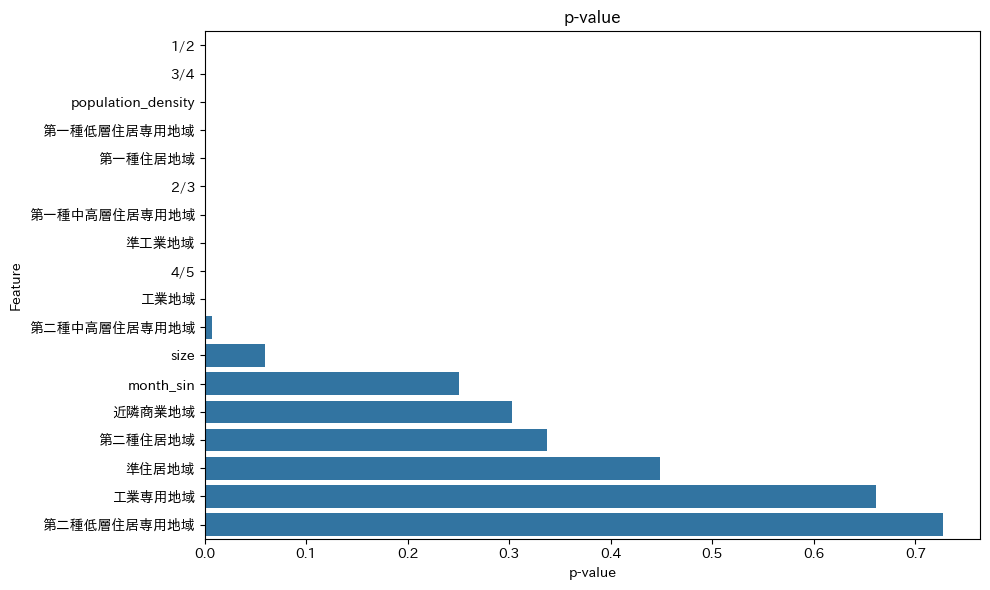

In [57]:
# p値を図で表示
p_values = result.pvalues
p_values_df = pd.DataFrame(p_values, columns=['p-value'])
p_values_df = p_values_df.reset_index()
p_values_df.columns = ['Feature', 'p-value']
p_values_df['Feature'] = p_values_df['Feature'].astype(str)
p_values_df['Feature'] = p_values_df['Feature'].str.replace('dummy_', '')
p_values_df['Feature'] = p_values_df['Feature'].str.replace('use_district_', '')
p_values_df = p_values_df.sort_values(by='p-value', ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='p-value', y='Feature', data=p_values_df)
plt.title("p-value")
plt.xlabel("p-value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


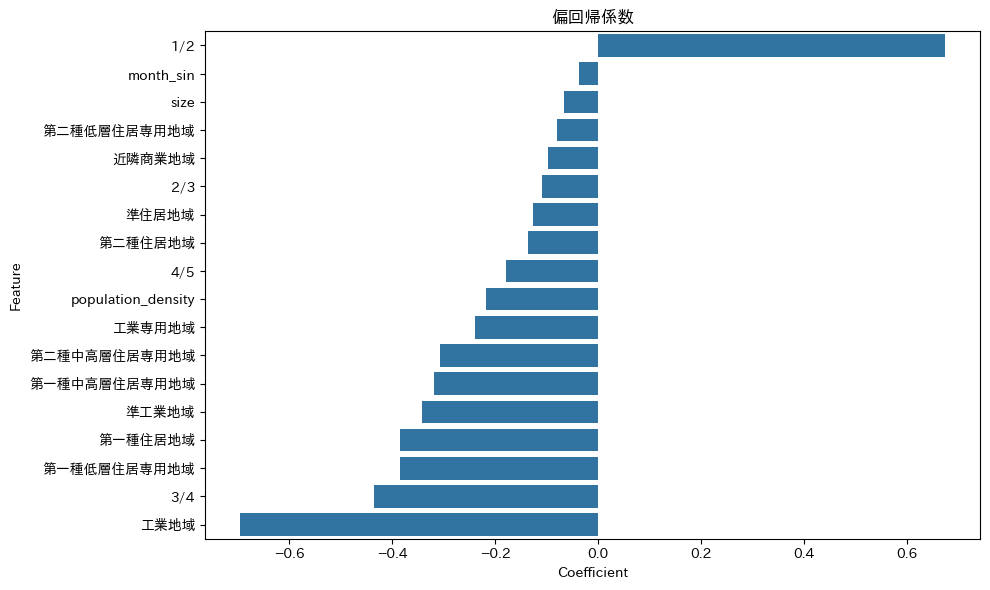

In [58]:
# 偏回帰係数を図で表示
coef = result.params
coef_df = pd.DataFrame(coef, columns=['Coefficient'])
coef_df = coef_df.reset_index()
coef_df.columns = ['Feature', 'Coefficient']
coef_df['Feature'] = coef_df['Feature'].astype(str)
coef_df['Feature'] = coef_df['Feature'].str.replace('dummy_', '')
coef_df['Feature'] = coef_df['Feature'].str.replace('use_district_', '')
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title("偏回帰係数")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()